# Intertidal Exposure calculation

Calculate the percentage time that intertidal regions are exposed (emersed) from tide coverage (seawater) by comparing the intertidal elevation against long-term local tide modelling

1. Select an area of interest from the interactive map by drawing a polygon around your area *and* using a marker to designate the location of the tide post for tidal modelling.
2. Extract the all-time NIDEM C2 values for the area of interest
3. Determine the input parameters for the tidal modelling including: 
    - modelling time period (ideally a full nodal cycle, 18.6 years, to incorporate the full range of tidal harmonics)
    - any filters on the tide modelling (e.g. solar exposure, seasonality, spring/neap tidal cycles etc)
4. Run the tidal model and create a relative cumulative frequency (CF) distribution of the results
5. Using xarray dataarrays of both the intertidal elevation (NIDEM) and the CF of the tidal modelling, re-index NIDEM against the CF
distribution to generate the relative percentage of time each elevation appears in the tidal modelling (aka the exposure/emersion)

In [1]:
## Import modules

# ## Install module for day/night calculations
!pip install sunriset
import sunriset

import datacube 
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import numpy as np
import xarray as xr
from tqdm import tqdm ## Show a smart progress meter for loops

from scipy.stats import cumfreq
from otps import TimePoint, predict_tide
# from otps import predict_tide
from dea_tools.dask import create_local_dask_cluster
from datacube.utils.cog import write_cog

import sys
sys.path.append("../Tools/dea_tools")
from coastal_temp import (select_aoi, 
                          exp_model, 
                          prep_aoi, 
                          plot_summary)

# import odc.geo.xr
from dea_tools.coastal import model_tides, pixel_tides


You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.


In [2]:
## Create datacube instance and local dask cluster

dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-8h4yhygo', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46853,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:42567,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/46015/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:34311,


In [26]:
# # Import required modules for coastal_temp script

# ## Install module for day/night calculations
# !pip install sunriset
import sunriset

from datacube.utils import geometry
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr
import numpy as np

from otps import TimePoint
from otps import predict_tide
import pytz
# import math
import datetime
from datetime import timedelta
from math import ceil

from scipy.signal import argrelmax 
from scipy.signal import argrelmin 
from scipy.interpolate import interp1d 
from shapely.geometry import Polygon

# from shapely.geometry import Polygon
from ipyleaflet import (Map, 
                        basemaps, 
                        DrawControl
                       )

from dea_tools.coastal import model_tides, pixel_tides


## Define the tide-modelling function

def exp_model(time_start, 
              time_end, 
              time_filter, 
              modelled_freq, 
              tidepost_lat, 
              tidepost_lon,
              model,
              directory,
              ds): 
    '''
    Recommended settings but may need updating depending on user:
    model="FES2014"
    directory="/home/jovyan/dev_intexp/dea-notebooks/tide_models_clipped"
    '''
    
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)

    # Use a tidal model to compute tide heights for each observation:  
    modelledtides = model_tides(
                x=tidepost_lon,
                y=tidepost_lat,
                time=all_timerange,
                model=model,
                directory=directory
                        )
    
    ## Rename and drop columns to match original workflow
    modelledtides = modelledtides.rename(columns={'tide_m':'tideheights'}
                                        ).drop(['x','y'], axis=1)
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')


    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
#     #modelledtides.drop('timerange', axis=1, inplace=True)
    
    ## Prepare data for use in solar modelling function (sunriset)
    ## Translate input dates to datetime
    format = '%Y-%m-%d %H:%M:%S'
    start = pd.to_datetime(time_start, format=format)
    end = pd.to_datetime(time_end, format=format)

    ## Calculate number of days between input dates
    diff = end-start

    ## Return difference in years
    yearsdiff = diff.days/365

    ## Round up to ensure all modelledtide datetimes are captured in solar model
    yearsdiff = int(ceil(yearsdiff))

    ## Identify variables for solar model input
    lat = tidepost_lat ## from tidepost
    long = tidepost_lon ## from tidepost
#     local_tz = local_tz  ## hardcoded for 3 Austral regions

    number_of_years = yearsdiff
    start_date = datetime.date(start.year, start.month, start.day) ## from query
    
    ## Create all required time filters
    ## Create dict to store filtered times
    filters = {}
    
    ## Create a filteredtides dataframe for the filters of interest
    for x in time_filter:
        
        if x == 'all_time':
            filteredtides = modelledtides
            filters[str(x)] = filteredtides

        elif x == 'daynight':

            ## Model sunrise and sunset
            sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)
           
            ## Model solar noon and midnight (Solar noon taken from sunriset module and solar midnight assumed to be 12 hours earlier)
            ## TODO: test that all Southern Hemisphere latitudes have solar noon occur after 12pm to ensure that the simple subtraction of 12 hours
            ## still holds continentally.https://gml.noaa.gov/grad/solcalc/ Preliminary checks using this NOAA tool indicate Darwin might be fine
            ## but that the winter months in Hobart might come close to having a 12pm solar noon.
            
            ## Set the index as a datetimeindex to match the modelledtide df
            sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
                        
            ## Calculate the solar noon and solar midnight time to identify the 'closest' day or night datetime when comparing against the modelledtides dataset.
            sun_df['Solar Noon dt'] = sun_df.index + sun_df['Solar Noon']
            sun_df['Solar Midnight dt'] = sun_df.index + (sun_df['Solar Noon'] - timedelta(hours=12))  ## Important assumption here: that Austral Solar Noon times 
            ## will always be after 12pm to enable a subtraction to determine the timing of Solar Midnight, and that Solar Midnight falls 12 hours prior to Solar Noon

            ## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
            daytime=pd.DataFrame(data = True, index=sun_df['Solar Noon dt'], columns=['Sunlight'])
            nighttime=pd.DataFrame(data = False, index=sun_df['Solar Midnight dt'], columns=['Sunlight'])
            DayNight = pd.concat([daytime, nighttime], join='outer')
            DayNight.sort_index(inplace=True)
            DayNight.index.rename('Datetime', inplace=True)

            ## Create an xarray object from the merged day/night dataframe
            day_night = xr.Dataset.from_dataframe(DayNight)

            ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
            ## timezone aware datetimeindexes 'from_dataframe' very well.
            modelledtides.index = modelledtides.index.tz_localize(tz=None)

            ## Create an xr Dataset from the modelledtides pd.dataframe
            mt = modelledtides.to_xarray()

            ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
            ## Modelled tides are designated as either day or night by how closely they fall to the Solar Noon and Solar Midnight times
            Solar=day_night.sel(Datetime=mt.local_timerange, method='nearest')

            ## Assign the day and night tideheight datasets
            SolarDayTides = mt.where(Solar.Sunlight==True)
            SolarNightTides = mt.where(Solar.Sunlight==False)

            filters['day'] = SolarDayTides
            filters['night'] = SolarNightTides

        elif x == 'springneap':
            ## Find all spring and neap high tides

            ## All peaks(maxima) in modelledtides 
            Max = argrelmax(modelledtides[0:-1].tideheights.values)
            Max = np.array(Max[0])

            ## Find higher tides in the maxima then the spring high tides 
            maxhigh = argrelmax(modelledtides.tideheights[Max].values)
            maxhigh = np.array(maxhigh[0])
            springhigh = argrelmax(modelledtides.tideheights[Max[maxhigh]].values)
            springhigh = np.array(springhigh[0]) 

            ## Find lower tides in the maxima then the neap high tides
            maxlow = argrelmin(modelledtides.tideheights[Max].values)
            maxlow = np.array(maxlow[0])
            neaphigh = argrelmin(modelledtides.tideheights[Max[maxlow]].values)
            neaphigh = np.array(neaphigh[0])

            ## Repeat to determine spring and neap low tides.

            ## All minima in modelledtides 
            Min = argrelmin(modelledtides[0:-1].tideheights.values)
            Min = np.array(Min[0])

            ## Find higher tides in the maxima then the spring high tides 
            minhigh = argrelmin(modelledtides.tideheights[Min].values)
            minhigh = np.array(minhigh[0])
            springlow = argrelmin(modelledtides.tideheights[Min[minhigh]].values)
            springlow = np.array(springlow[0])

            ## Find lower tides in the maxima then the neap high tides
            minlow = argrelmax(modelledtides.tideheights[Min].values)
            minlow = np.array(minlow[0])
            neaplow = argrelmax(modelledtides.tideheights[Min[minlow]].values)
            neaplow = np.array(neaplow[0])

            # Add column to modelledtides to plot without using datetime values
            modelledtides['count'] = np.arange(0,len(modelledtides),1)

            ## Interpolate the high and low spring and neap curves
            neap_high_linear = interp1d(Max[maxlow], modelledtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['neap_high_interp'] = neap_high_linear(modelledtides['count'])

            spring_high_linear = interp1d(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['spring_high_interp'] = spring_high_linear(modelledtides['count'])

            neap_low_linear = interp1d(Min[minlow], modelledtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['neap_low_interp'] = neap_low_linear(modelledtides['count'])

            spring_low_linear = interp1d(Min[minhigh], modelledtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['spring_low_interp'] = spring_low_linear(modelledtides['count'])

            ## Extract datetimeindex for each dataslice
            spring_high = modelledtides.tideheights[Max[maxhigh[springhigh]]].index
            spring_low = modelledtides.tideheights[Min[minhigh[springlow]]].index
            neap_high = modelledtides.tideheights[Max[maxlow[neaphigh]]].index
            neap_low = modelledtides.tideheights[Min[minlow[neaplow]]].index
            hightide = modelledtides[modelledtides.tideheights > modelledtides.neap_high_interp].index
            lowtide = modelledtides[modelledtides.tideheights < modelledtides.neap_low_interp].index

                            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in hightide.array)
            filteredtides['timerange'] = hightide
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters['hightide'] = filteredtides
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in lowtide.array)
            filteredtides['timerange'] = lowtide
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters['lowtide'] = filteredtides
            
                            ## Filtering model
            
            # ## Plot

            #     # Add column to modelledtides to plot without using datetime values
            # modelledtides['count'] = np.arange(0,len(modelledtides),1)
            #     # all modelled tides
            # plt.plot(modelledtides[0:-1]['count'], modelledtides[0:-1].tideheights) ## all modelled tide heights
            #     # spring and neap high tides
            # # plt.plot(Max, modelledtides.tideheights[Max], "X") ## all local maxima (orange)
            # # plt.plot(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
            # plt.plot(Max[maxhigh[springhigh]], modelledtides.tideheights[Max[maxhigh[springhigh]]], "o", color='black') ##SPRING HIGH TIDES!! (black)
            # plt.plot(Max[maxlow[neaphigh]], modelledtides.tideheights[Max[maxlow[neaphigh]]], "o", color='red') ##NEAP HIGH TIDES!! (red)
            #     # spring and neap low tides
            # # plt.plot(Min, modelledtides.tideheights[Min], "X") ## all local maxima (orange)
            # # plt.plot(Min[minhigh], modelledtides.tideheights[Min[minhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
            # plt.plot(Min[minhigh[springlow]], modelledtides.tideheights[Min[minhigh[springlow]]], "o", color='black') ##SPRING LOW TIDES!! (black)
            # plt.plot(Min[minlow[neaplow]], modelledtides.tideheights[Min[minlow[neaplow]]], "o", color='red') ##NEAP LOW TIDES!! (red)

        elif x == 'dry':
            dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
                        |(localtides.month == 11)
                        |(localtides.month == 12)
                        |(localtides.month == 1)
                        |(localtides.month == 2)
                        |(localtides.month == 3)
                        ])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
            filteredtides['timerange'] = dry
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'wet':
            wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
                        |(localtides.month == 5)
                        |(localtides.month == 6)
                        |(localtides.month == 7)
                        |(localtides.month == 8)
                        |(localtides.month == 9)
                        ])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
            filteredtides['timerange'] = wet
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'summer':
            summer = localtides.drop(localtides[localtides.quarter != 1])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
            filteredtides['timerange'] = summer
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'autumn':
            autumn = localtides.drop(localtides[localtides.quarter != 2])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
            filteredtides['timerange'] = autumn
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'winter':
            autumn = localtides.drop(localtides[localtides.quarter != 3])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
            filteredtides['timerange'] = winter
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'spring':
            spring = localtides.drop(localtides[localtides.quarter != 4])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
            filteredtides['timerange'] = spring
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Jan':
            Jan = localtides.drop(localtides[localtides.month != 1])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
            filteredtides['timerange'] = Jan
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Feb':
            Feb = localtides.drop(localtides[localtides.month != 2])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
            filteredtides['timerange'] = Feb
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Mar':
            Mar = localtides.drop(localtides[localtides.month != 3])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
            filteredtides['timerange'] = Mar
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Apr':
            Apr = localtides.drop(localtides[localtides.month != 4])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
            filteredtides['timerange'] = Apr
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'May':
            May = localtides.drop(localtides[localtides.month != 5])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
            filteredtides['timerange'] = May
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Jun':
            Jun = localtides.drop(localtides[localtides.month != 6])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
            filteredtides['timerange'] = Jun
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Jul':
            Jul = localtides.drop(localtides[localtides.month != 7])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
            filteredtides['timerange'] = Jul
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Aug':
            Aug = localtides.drop(localtides[localtides.month != 8])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
            filteredtides['timerange'] = Aug
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Sep':
            Sep = localtides.drop(localtides[localtides.month != 9])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
            filteredtides['timerange'] = Sep
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Oct':
            Oct = localtides.drop(localtides[localtides.month != 10])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
            filteredtides['timerange'] = Oct
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Nov':
            Nov = localtides.drop(localtides[localtides.month != 11])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
            filteredtides['timerange'] = Nov
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Dec':
            Dec = localtides.drop(localtides[localtides.month != 12])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
            filteredtides['timerange'] = Dec
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides
        
        elif x == 'wet_springneap':
            wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
                        |(localtides.month == 5)
                        |(localtides.month == 6)
                        |(localtides.month == 7)
                        |(localtides.month == 8)
                        |(localtides.month == 9)
                        ])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
            filteredtides['timerange'] = wet
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides
            
#                     elif x == 'springneap':
            ## Find all spring and neap high tides

            ## All peaks(maxima) in modelledtides 
            Max = argrelmax(filteredtides[0:-1].tideheights.values)
            Max = np.array(Max[0])

            ## Find higher tides in the maxima then the spring high tides 
            maxhigh = argrelmax(filteredtides.tideheights[Max].values)
            maxhigh = np.array(maxhigh[0])
            springhigh = argrelmax(filteredtides.tideheights[Max[maxhigh]].values)
            springhigh = np.array(springhigh[0]) 

            ## Find lower tides in the maxima then the neap high tides
            maxlow = argrelmin(filteredtides.tideheights[Max].values)
            maxlow = np.array(maxlow[0])
            neaphigh = argrelmin(filteredtides.tideheights[Max[maxlow]].values)
            neaphigh = np.array(neaphigh[0])

            ## Repeat to determine spring and neap low tides.

            ## All minima in modelledtides 
            Min = argrelmin(filteredtides[0:-1].tideheights.values)
            Min = np.array(Min[0])

            ## Find higher tides in the maxima then the spring high tides 
            minhigh = argrelmin(filteredtides.tideheights[Min].values)
            minhigh = np.array(minhigh[0])
            springlow = argrelmin(filteredtides.tideheights[Min[minhigh]].values)
            springlow = np.array(springlow[0])

            ## Find lower tides in the maxima then the neap high tides
            minlow = argrelmax(filteredtides.tideheights[Min].values)
            minlow = np.array(minlow[0])
            neaplow = argrelmax(filteredtides.tideheights[Min[minlow]].values)
            neaplow = np.array(neaplow[0])

            # Add column to modelledtides to plot without using datetime values
            filteredtides['count'] = np.arange(0,len(filteredtides),1)

#             ## Interpolate the high and low spring and neap curves
#             neap_high_linear = interp1d(Max[maxlow], filteredtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
#             filteredtides['neap_high_interp'] = neap_high_linear(filteredtides['count'])

# #             spring_high_linear = interp1d(Max[maxhigh], filteredtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# #             filteredtides['spring_high_interp'] = spring_high_linear(filteredtides['count'])

#             neap_low_linear = interp1d(Min[minlow], filteredtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
#             filteredtides['neap_low_interp'] = neap_low_linear(filteredtides['count'])

# #             spring_low_linear = interp1d(Min[minhigh], filteredtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# #             filteredtides['spring_low_interp'] = spring_low_linear(filteredtides['count'])

            ## Extract datetimeindex for each dataslice
            spring_high = filteredtides.tideheights[Max[maxhigh[springhigh]]].index
            spring_low = filteredtides.tideheights[Min[minhigh[springlow]]].index
            neap_high = filteredtides.tideheights[Max[maxlow[neaphigh]]].index
            neap_low = filteredtides.tideheights[Min[minlow[neaplow]]].index
#             hightide = filteredtides[filteredtides.tideheights > filteredtides.neap_high_interp].index
#             lowtide = filteredtides[filteredtides.tideheights < filteredtides.neap_low_interp].index

#                             ## Filtering modelledtides by nominated timerange
#             filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in hightide.array)
#             filteredtides1['timerange'] = hightide
#             filteredtides1.set_index('timerange', inplace=True)
#             filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
#             filters['wet_hightide'] = filteredtides1
            
#                             ## Filtering modelledtides by nominated timerange
#             filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in lowtide.array)
#             filteredtides1['timerange'] = lowtide
#             filteredtides1.set_index('timerange', inplace=True)
#             filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
#             filters['wet_lowtide'] = filteredtides1
            
#                             ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in spring_high.array)
            filteredtides1['timerange'] = spring_high
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_spring_high'] = filteredtides1
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in spring_low.array)
            filteredtides1['timerange'] = spring_low
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_spring_low'] = filteredtides1
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in neap_high.array)
            filteredtides1['timerange'] = neap_high
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_neap_high'] = filteredtides1
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in neap_low.array)
            filteredtides1['timerange'] = neap_low
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_neap_low'] = filteredtides1

        else:
            print('''
            Please select one of the following `time_filter`s: 
            all_time, day, night, springneap, wet, dry, summer, autumn, winter, 
            spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, 'wet_springneap'
            ''')
    
        print ('Complete: datetime filtering. Starting: wet/dry masking')
        
        '''
        ## Add Exposure calculations here
        '''
        

    return filters#, pxpc2, modelledtides, 

In [4]:
## Draw a polygon around your (small) area of interest. Also use a marker to designate the location of your tide modelling

m, master_gdf, roi = select_aoi()
display (m)

Map(center=[-32.13054578933222, 136.10234378608968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [5]:
## Prepare your selections for analysis. Note that this is a per-pixel analysis. Consequently,
## a small area of interest is advised to minimise computation time.

tp, working_gdf, geom = prep_aoi(roi, master_gdf)

In [6]:
## Set the user-defined variables 

## Define the tidal-modelling period start and end dates. This is the period over which intertidal
## exposure will be calculated. Ideally, this period should be an 18.6 year window to account
## for the full average range of astronomical forcings on the tide (e.g. Haigh et al., 2011).
## However, a shorter window is advised in this application to minimise the computation time.
## Note that if a filter is applied to the tide-model, e.g. restricted date or tide range, then
## a wide tidal-modelling period may be achievable on this platform.

## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '1985-12-01 00:00:00'
time_end = '2023-01-01 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# ## Set the filter to apply for the exposure modelling. Options:
'''
    'all_time',
    'daynight', 
    'springneap',
    'wet',
    'dry',
    'summer',
    'autumn',
    'winter',
    'spring',
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
'''
time_filter = ['all_time']

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 100000, "y": 100000},
    "geopolygon": geom
        }

In [7]:
## Load NIDEM elevation data

ds = dc.load(**query)
ds2 = ds.where(ds.nidem > ds.nidem.min())
ds2 = ds2.compute() ## Bury this in a later func

In [ ]:
## Testing cell

# %cd ..
# %cd '/dev_intexp/dea-notebooks/tide_models_clipped'

In [8]:
# ## Testing cell - OTPS method

# def exp_model(time_start, 
#               time_end, 
#               time_filter, 
#               modelled_freq, 
#               tidepost_lat, 
#               tidepost_lon, 
#               ds):    
#     ## Run tidal modelling

#     # Generate range of times covering entire period of satellite record
#     all_timerange = pd.date_range(start=time_start,
#                                   end=time_end,
#                                   freq=modelled_freq)
#     all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

#     # Use the tidal model to compute tide heights for each observation:  
#     all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
#                       for dt in all_datetimes]
#     all_predictedtides = predict_tide(all_timepoints)   
#     all_tideheights = [predictedtide.tide_m for predictedtide 
#                         in all_predictedtides]
    
#         ## Save modelled tides as dataframe
#         ## Firstly convert the dates to series
#     all_timerange = all_timerange.to_series()
#         ## Save dates and tideheights to pd.DataFrame
#     modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                        'tideheights': all_tideheights})
    
# #     print ('Complete: Tidal modelling. Starting: Local timezone conversion')
#     return modelledtides

# modelledtides = exp_model(time_start,
#                                   time_end,
#                                   time_filter,
#                                   modelled_freq,
#                                   tidepost_lat = tp[1],# = -17.420604,
#                                   tidepost_lon = tp[0],# = 140.665169,
#                                   ds=ds2)
# print (modelledtides)

In [9]:
# ## Testing cell - FES2014 method



# #     modelledtides

# #         ## Save modelled tides as dataframe
# #         ## Firstly convert the dates to series
# #     all_timerange = all_timerange.to_series()
# #         ## Save dates and tideheights to pd.DataFrame
# #     modelledtides = pd.DataFrame(data={'timerange': all_timerange,
# #                        'tideheights': all_tideheights})
    
# # #     print ('Complete: Tidal modelling. Starting: Local timezone conversion')
#     return modelledtides

In [27]:
## Use the exp_model (needs renaming) function to generate the tidal model dataset

filters = exp_model(time_start,
                          time_end,
                          time_filter,
                          modelled_freq,
                          tidepost_lat = tp[1],# = -17.420604,
                          tidepost_lon = tp[0],# = 140.665169,
                          model="FES2014",
                          directory="/home/jovyan/dev_intexp/dea-notebooks/tide_models_clipped",
                          ds=ds2)


Complete: Tidal modelling. Starting: Local timezone conversion
Timezone set to Australia/West
Complete: datetime filtering. Starting: wet/dry masking


In [28]:
keys=[]
for key in filters.keys():
    print (key)
    keys.append(key)
    
## For identification of filter to use in exposure calculation below:
n=0

all_time


In [29]:
filters

{'all_time':                            tideheights
 local_timerange                       
 1985-12-01 08:00:00+08:00    -2.473913
 1985-12-01 08:30:00+08:00    -1.780548
 1985-12-01 09:00:00+08:00    -1.016751
 1985-12-01 09:30:00+08:00    -0.239315
 1985-12-01 10:00:00+08:00     0.511596
 ...                                ...
 2023-01-01 06:00:00+08:00     1.002650
 2023-01-01 06:30:00+08:00     0.742581
 2023-01-01 07:00:00+08:00     0.458268
 2023-01-01 07:30:00+08:00     0.177701
 2023-01-01 08:00:00+08:00    -0.094443
 
 [650161 rows x 1 columns]}

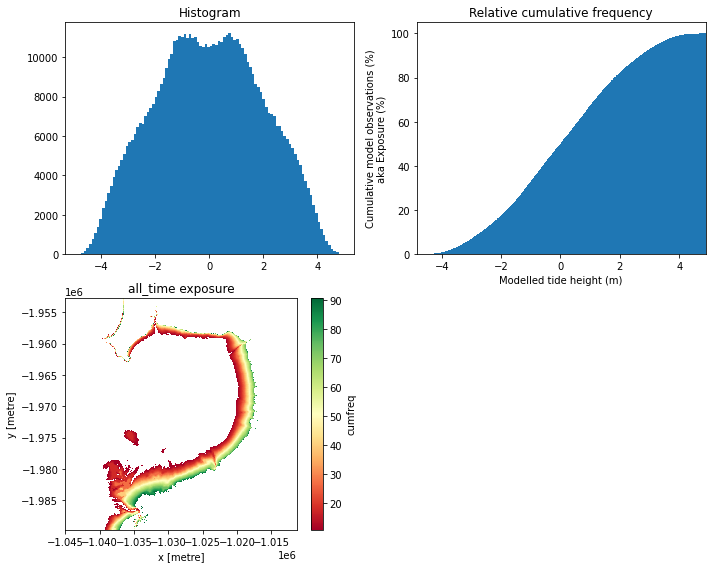

In [30]:
## Calculate the cumulative frequency distribution of the modelled tides
## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html

## Extract modelled tideheights as np.array
modelledtides = (np.array(filters[keys[n]].tideheights))

## Convert erroneous values to NaNs. This was an issue in the calculation of 'lowtide'. 
## TODO: check why erroneous values occurred at all.
modelledtides = pd.to_numeric(modelledtides, errors='coerce')

## Drop nan values from the tideheight array
## `~` is equivalent to np.logical_not after 
## https://www.geeksforgeeks.org/how-to-remove-nan-values-from-a-given-numpy-array/
modelledtides = modelledtides[~(pd.isnull(modelledtides))]

## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally 
## consistent bin size of 0.05m (arbitrary bin size)
binsize = 0.01
bins = (modelledtides.max() - modelledtides.min())/binsize

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

## Save the *relative* cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights

CFdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
CF_df = pd.DataFrame(data=CFdict)

## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
shifted = CF_df.tideheight_max.shift(periods=1)
updatedvalue = CF_df.tideheight_max[0] - binsize
shifted.update(pd.Series([updatedvalue], index=[0]))

CF_df['tideheight_min']=shifted

CF_df['Elevation_midpoint'] = (CF_df.tideheight_max + CF_df.tideheight_min)/2
CF_df = CF_df.set_index('Elevation_midpoint')

## Create xarray object from cumulative frequency dataframe
CF_ds = xr.Dataset.from_dataframe(CF_df)


## Calculate exposure and plot

# ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# ## relative cumulative frequencies for those same elevations into a new dataset.
Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# ## nans in the original NIDEM dataset.
Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

## Plot
# Exp_cf.plot(cmap='RdYlGn', figsize=(10,5))

## Visualise the distribution of observations in the tidal model dataset and the relative CF distribution

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2,2,1)#(1, 2, 1)
ax2 = fig.add_subplot(2,2,2)#(1, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax1.hist(modelledtides, bins=100)
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
ax2.set_title('Relative cumulative frequency')
ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
ax2.set_xlabel('Modelled tide height (m)')
ax2.set_xlim([x.min(), x.max()])
# ax3.plot(Exp_cf)
Exp_cf.plot(ax=ax3, cmap='RdYlGn')
plt.title(str(keys[n]) + ' exposure')
fig.tight_layout()

In [ ]:
## Calculate the cumulative frequency distribution of the modelled tides
## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html

## Extract modelled tideheights as np.array
modelledtides = (np.array(filters[keys[3]].tideheights))

## Convert erroneous values to NaNs. This was an issue in the calculation of 'lowtide'. 
## TODO: check why erroneous values occurred at all.
modelledtides = pd.to_numeric(modelledtides, errors='coerce')

## Drop nan values from the tideheight array
## `~` is equivalent to np.logical_not after 
## https://www.geeksforgeeks.org/how-to-remove-nan-values-from-a-given-numpy-array/
modelledtides = modelledtides[~(pd.isnull(modelledtides))]

## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally 
## consistent bin size of 0.05m (arbitrary bin size)
binsize = 0.01
bins = (modelledtides.max() - modelledtides.min())/binsize

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

## Save the *relative* cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights

CFdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
CF_df = pd.DataFrame(data=CFdict)

## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
shifted = CF_df.tideheight_max.shift(periods=1)
updatedvalue = CF_df.tideheight_max[0] - binsize
shifted.update(pd.Series([updatedvalue], index=[0]))

CF_df['tideheight_min']=shifted

CF_df['Elevation_midpoint'] = (CF_df.tideheight_max + CF_df.tideheight_min)/2
CF_df = CF_df.set_index('Elevation_midpoint')

## Create xarray object from cumulative frequency dataframe
CF_ds = xr.Dataset.from_dataframe(CF_df)


## Calculate exposure and plot

# ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# ## relative cumulative frequencies for those same elevations into a new dataset.
Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# ## nans in the original NIDEM dataset.
Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

## Plot
# Exp_cf.plot(cmap='RdYlGn', figsize=(10,5))

## Visualise the distribution of observations in the tidal model dataset and the relative CF distribution

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2,2,1)#(1, 2, 1)
ax2 = fig.add_subplot(2,2,2)#(1, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax1.hist(modelledtides, bins=100)
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
ax2.set_title('Relative cumulative frequency')
ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
ax2.set_xlabel('Modelled tide height (m)')
ax2.set_xlim([x.min(), x.max()])
# ax3.plot(Exp_cf)
Exp_cf.plot(ax=ax3, cmap='RdYlGn')
plt.title(str(keys[3]) + ' exposure')
fig.tight_layout()

In [ ]:
# Save a single time-slice as a cloud-optimised geotiff

rgb_da = Exp_cf.isel(time=0)#.to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=rgb_da,
          fname='binsize_'+str(binsize)+'_'+str(keys[n])+'filter_exp_CFmethod.tif',
          overwrite=True)


In [ ]:
# def exp_model(time_start, 
#               time_end, 
#               time_filter, 
#               modelled_freq, 
#               tidepost_lat, 
#               tidepost_lon, 
#               ds):    
#     ## Run tidal modelling

#     # Generate range of times covering entire period of satellite record
#     all_timerange = pd.date_range(start=time_start,
#                                   end=time_end,
#                                   freq=modelled_freq)
#     all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

#     # Use the tidal model to compute tide heights for each observation:  
#     all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
#                       for dt in all_datetimes]
#     all_predictedtides = predict_tide(all_timepoints)   
#     all_tideheights = [predictedtide.tide_m for predictedtide 
#                         in all_predictedtides]
#         ## Save modelled tides as dataframe
#         ## Firstly convert the dates to series
#     all_timerange = all_timerange.to_series()
#         ## Save dates and tideheights to pd.DataFrame
#     modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                        'tideheights': all_tideheights})
    
#     print ('Complete: Tidal modelling. Starting: Local timezone conversion')

#     '''---------------------------------------------------------'''
#     ## Automate timezone selection based on location of tidepost
#     ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
#     if tidepost_lon <= 129.0:
#         timezone = 'Australia/West'
#         local_tz = 8
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/North'
#         local_tz = 9.5
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
#         timezone = 'Australia/South'
#         local_tz = 9.5
#     elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/Queensland'
#         local_tz = 10
#     elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
#         timezone = 'Australia/NSW'
#         local_tz = 10
#     else:
#         print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
#     print('Timezone set to', timezone)
    
#     ## Convert time_start and time_end to datetime objects in local timezone
#     time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
#     time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
#     ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
#     localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

#     ## Convert tz-aware index to local timezone
#     localtides = localtides.tz_convert(timezone)
    
#     ## Reset the index of modelledtides to reflect local times
#     modelledtides['local_timerange'] = localtides
#     modelledtides.set_index('local_timerange', inplace=True)
#     modelledtides.drop('timerange', axis=1, inplace=True)
    
#     ## Prepare data for use in solar modelling function (sunriset)
#     ## Translate input dates to datetime
#     format = '%Y-%m-%d %H:%M:%S'
#     start = pd.to_datetime(time_start, format=format)
#     end = pd.to_datetime(time_end, format=format)

#     ## Calculate number of days between input dates
#     diff = end-start

#     ## Return difference in years
#     yearsdiff = diff.days/365

#     ## Round up to ensure all modelledtide datetimes are captured in solar model
#     yearsdiff = int(ceil(yearsdiff))

#     ## Identify variables for solar model input
#     lat = tidepost_lat ## from tidepost
#     long = tidepost_lon ## from tidepost
# #     local_tz = local_tz  ## hardcoded for 3 Austral regions

#     number_of_years = yearsdiff
#     start_date = datetime.date(start.year, start.month, start.day) ## from query
    
#     ## Create all required time filters
#     ## Create dict to store filtered times
#     filters = {}
    
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides

#         elif x == 'daynight':

#             ## Model sunrise and sunset
#             sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)

# #             ## Return sunrise/sunset in hh:mm:ss format (str)
# #             sun_df['Sunrise hh:mm:ss'] = sun_df['Sunrise'].apply(
# #                     lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
# #             sun_df['Sunset hh:mm:ss'] = sun_df['Sunset'].apply(
# #                     lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
            
#             ## Model solar noon and midnight (Solar noon taken from sunriset module and solar midnight assumed to be 12 hours earlier)
#             ## TODO: test that all Southern Hemisphere latitudes have solar noon occur after 12pm to ensure that the simple subtraction of 12 hours
#             ## still holds continentally.https://gml.noaa.gov/grad/solcalc/ Preliminary checks using this noaa tool indicate Darwin might be fine
#             ## but that the winter months in Hobart might close to having a 12pm solar noon.
            
# #             ## Return solar noon in hh:mm:ss format (str)
# #             sun_df['Solar Noon hh:mm:ss'] = sun_df['Solar Noon'].apply(
# #                     lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
# #             ## Calculate solar midnight in hh:mm:ss format (str), assuming 12 hour delay from solar noon (See above comment on assumptions)
# #             sun_df['Solar Midnight hh:mm:ss'] = (sun_df['Solar Noon'] - timedelta(hours=12)).apply(
# #                     lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))

# #             # Drop accessory columns
# #             sun_df = sun_df[['Solar Noon', 'Sunrise hh:mm:ss','Sunset hh:mm:ss','Solar Noon hh:mm:ss', 'Solar Midnight hh:mm:ss']]

#             ## Set the index as a datetimeindex to match the modelledtide df
#             sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
            
#             # ---
            
#             ## Calculate the solar noon and solar midnight time to identify the 'closest' day or night datetime when comparing against the modelledtides dataset.
#             sun_df['Solar Noon dt'] = sun_df.index + sun_df['Solar Noon']
#             sun_df['Solar Midnight dt'] = sun_df.index + (sun_df['Solar Noon'] - timedelta(hours=12))  ## Important assumption here: that Austral Solar Noon times 
#             ## will always be after 12pm to enable a subtraction to determine the timing of Solar Midnight, and that Solar Midnight falls 12 hours prior to Solar Noon

#             ## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
#             daytime=pd.DataFrame(data = True, index=sun_df['Solar Noon dt'], columns=['Sunlight'])
#             nighttime=pd.DataFrame(data = False, index=sun_df['Solar Midnight dt'], columns=['Sunlight'])
#             DayNight = pd.concat([daytime, nighttime], join='outer')
#             DayNight.sort_index(inplace=True)
#             DayNight.index.rename('Datetime', inplace=True)

#             ## Create an xarray object from the merged day/night dataframe
#             day_night = xr.Dataset.from_dataframe(DayNight)

#             ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
#             ## timezone aware datetimeindexes 'from_dataframe' very well.
#             modelledtides.index = modelledtides.index.tz_localize(tz=None)

#             ## Create an xr Dataset from the modelledtides pd.dataframe
#             mt = modelledtides.to_xarray()

#             ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
#             ## Modelled tides are designated as either day or night by how closely they fall to the Solar Noon and Solar Midnight times
#             Solar=day_night.sel(Datetime=mt.local_timerange, method='nearest')

#             ## Assign the day and night tideheight datasets
#             SolarDayTides = mt.where(Solar.Sunlight==True)
#             SolarNightTides = mt.where(Solar.Sunlight==False)

#             filters['day'] = SolarDayTides
#             filters['night'] = SolarNightTides
            
#             # ---
            
#     return  filters


In [ ]:
# ## Efficiency improvements for calcuation of daytime/nighttime exposure

# filters = exp_model(time_start,
#                       time_end,
#                       time_filter,
#                       modelled_freq,
#                       tidepost_lat = tp[1],# = -17.420604,
#                       tidepost_lon = tp[0],# = 140.665169,
#                       ds=ds2)

In [ ]:
# ## Calculate the solar noon and solar midnight time to identify the 'closest' day or night datetime when comparing against the modelledtides dataset.
# sun_df['Solar Noon dt'] = sun_df.index + sun_df['Solar Noon']
# sun_df['Solar Midnight dt'] = sun_df.index + (sun_df['Solar Noon'] - timedelta(hours=12))  ## Important assumption here: that Austral Solar Noon times 
# ## will always be after 12pm to enable a subtraction to determine the timing of Solar Midnight, and that Solar Midnight falls 12 hours prior to Solar Noon

# ## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
# daytime=pd.DataFrame(data = True, index=sun_df['Solar Noon dt'], columns=['Sunlight'])
# nighttime=pd.DataFrame(data = False, index=sun_df['Solar Midnight dt'], columns=['Sunlight'])
# DayNight = pd.concat([daytime, nighttime], join='outer')
# DayNight.sort_index(inplace=True)
# DayNight.index.rename('Datetime', inplace=True)

# ## Create an xarray object from the merged day/night dataframe
# day_night = xr.Dataset.from_dataframe(DayNight)

# ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
# ## timezone aware datetimeindexes 'from_dataframe' very well.
# modelledtides.index = modelledtides.index.tz_localize(tz=None)

# ## Create an xr Dataset from the modelledtides pd.dataframe
# mt = modelledtides.to_xarray()

# ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
# ## Modelled tides are designated as either day or night by how closely they fall to the Solar Noon and Solar Midnight times
# Solar=day_night.sel(Datetime=mt.local_timerange, method='nearest')

# ## Assign the day and night tideheight datasets
# SolarDayTides = mt.where(Solar.Sunlight==True)
# SolarNightTides = mt.where(Solar.Sunlight==False)

# filters['day'] = SolarDayTides
# filters['night'] = SolarNightTides

In [ ]:
# for x in filters:
#     print (x)
# # filters[0]

In [ ]:
# ## Cumulative frequency calculation
# ## Todo: loop this cell to repeat for all nominated filters

# ## Calculate the cumulative frequency distribution of the modelled tides
# ## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html

# ## Extract modelled tideheights as np.array
# # modelledtides = (np.array(filters[keys[0]].tideheights))
# modelledtides = np.array(filters['day'].tideheights)

# ## Drop nan values from the tideheight array
# ## `~` is equivalent to np.logical_not after 
# ## https://www.geeksforgeeks.org/how-to-remove-nan-values-from-a-given-numpy-array/
# modelledtides = modelledtides[~(np.isnan(modelledtides))]

# ## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally 
# ## consistent bin size of 0.05m (arbitrary bin size)
# binsize = 0.01
# # bins = (filters[keys[0]].tideheights.max() - filters[keys[0]].tideheights.min())/binsize
# bins = (modelledtides.max() - modelledtides.min())/binsize

# ## Calculate cumulative frequencies
# res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# # Calculate space of values for x
# x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

In [ ]:
# ## Visualise the distribution of observations in the tidal model dataset and the relative CF distribution

# fig = plt.figure(figsize=(10, 4))
# ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2)
# ax1.hist(modelledtides, bins=100)
# ax1.set_title('Histogram')
# ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
# ax2.set_title('Relative cumulative frequency')
# ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
# ax2.set_xlabel('Modelled tide height (m)')
# ax2.set_xlim([x.min(), x.max()])
# fig.tight_layout()

In [ ]:
# ## Save the *relative* cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights


# CFdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
# CF_df = pd.DataFrame(data=CFdict)

# ## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
# shifted = CF_df.tideheight_max.shift(periods=1)
# updatedvalue = CF_df.tideheight_max[0] - binsize
# shifted.update(pd.Series([updatedvalue], index=[0]))

# CF_df['tideheight_min']=shifted

# CF_df['Elevation_midpoint'] = (CF_df.tideheight_max + CF_df.tideheight_min)/2
# CF_df = CF_df.set_index('Elevation_midpoint')

# ## Create xarray object from cumulative frequency dataframe
# CF_ds = xr.Dataset.from_dataframe(CF_df)


In [ ]:
# ## Calculate exposure and plot

# # ## Calculate the exposure dataset by indexing the NIDEM elevations against the 
# # ## relative cumulative frequencies for those same elevations into a new dataset.
# Exposure= CF_ds.sel(Elevation_midpoint=ds2.nidem, method='nearest')

# # ## Also, replace nan values in NIDEM with -9999 values to enable masking of
# # ## non-intertidal areas. This is a workaround for the .sel function failing to handle
# # ## nans in the original NIDEM dataset.
# Exp_cf = Exposure.cumfreq.where(ds2.nidem.fillna(-9999) != -9999)

# ## Plot
# Exp_cf.plot(cmap='RdYlGn', figsize=(10,5))